In [1]:
%matplotlib inline
import numpy as np
import glob
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import random
import os
from sklearn.preprocessing import label_binarize
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
import pickle
from scipy import stats
from scipy.stats import gaussian_kde

In [2]:
signal = pd.read_csv('process_data/signal_pred.csv',sep=',')
background = pd.read_csv('process_data/background_pred.csv',sep=',')

In [3]:
signal['signal'] = 1
background['signal'] = 0

In [4]:
analysis = pd.concat([signal, background], ignore_index=True)

In [5]:
analysis.head()

,Unnamed: 0,pt_j1,m_j1,eta_j1,phi_j1,E_j1,pt_j2,m_j2,eta_j2,phi_j2,...,deltaR2_sj23,deltaR2_sj24,deltaR2_sj34,n_subjets1,n_subjets2,event_idx,img_name,P_BG,P_SIG,signal
0,0,1210.415787,129.499352,-0.744836,-2.883347,1567.345300,1091.785816,155.362262,1.060534,0.264977,...,0.000000,0.000000,0.00000,1,1,4,4.png,0.378957,0.621043,1
1,1,1787.625573,99.168898,-0.934612,1.185407,2628.753873,1717.649940,515.054419,-1.044915,-1.955165,...,2.512072,2.512072,0.00000,1,2,8,8.png,0.027786,0.972214,1
2,2,1368.776255,104.840764,-1.136360,1.353935,2354.162865,1283.549433,452.024576,0.053019,-1.781479,...,1.015464,1.926491,2.05649,1,3,19,19.png,0.288431,0.711569,1
3,3,1659.355146,110.390275,-0.348487,2.475010,1764.594154,1634.435917,487.949083,0.102619,-0.649581,...,0.452664,0.452664,0.00000,1,2,24,24.png,0.093520,0.906480,1
4,4,1827.270115,551.510487,0.208524,-0.979991,1946.889764,1799.302155,108.942106,-0.452693,2.177153,...,0.000000,0.000000,0.00000,2,1,33,33.png,0.027147,0.972853,1


In [6]:
analysis.drop(['event_idx','img_name','Unnamed: 0', 'P_BG', 'P_SIG'], axis=1, inplace=True)

In [7]:
analysis.head()

,pt_j1,m_j1,eta_j1,phi_j1,E_j1,pt_j2,m_j2,eta_j2,phi_j2,E_j2,...,deltaR1_sj34,deltaR2_sj12,deltaR2_sj13,deltaR2_sj14,deltaR2_sj23,deltaR2_sj24,deltaR2_sj34,n_subjets1,n_subjets2,signal
0,1210.415787,129.499352,-0.744836,-2.883347,1567.345300,1091.785816,155.362262,1.060534,0.264977,1772.340209,...,0.0,1.096969,1.096969,1.096969,0.000000,0.000000,0.00000,1,1,1
1,1787.625573,99.168898,-0.934612,1.185407,2628.753873,1717.649940,515.054419,-1.044915,-1.955165,2791.763302,...,0.0,0.558392,2.013673,2.013673,2.512072,2.512072,0.00000,1,2,1
2,1368.776255,104.840764,-1.136360,1.353935,2354.162865,1283.549433,452.024576,0.053019,-1.781479,1362.520063,...,0.0,0.605989,0.517361,1.698000,1.015464,1.926491,2.05649,1,3,1
3,1659.355146,110.390275,-0.348487,2.475010,1764.594154,1634.435917,487.949083,0.102619,-0.649581,1713.973621,...,0.0,0.681621,0.778878,0.778878,0.452664,0.452664,0.00000,1,2,1
4,1827.270115,551.510487,0.208524,-0.979991,1946.889764,1799.302155,108.942106,-0.452693,2.177153,1989.823176,...,0.0,2.223210,2.223210,2.223210,0.000000,0.000000,0.00000,2,1,1


In [8]:
X = analysis.drop(['signal'], axis=1)
y = analysis['signal']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)

In [9]:
bdt_SAMME_R = pickle.load(open('bdt_SAMME_R_BL3.sav', 'rb'))

In [21]:
from matplotlib import rc
plt.rcParams['font.size'] = 18
rc('text', usetex=True)
rc('font',**{'family':'sans-serif', 'sans-serif':['cmr']})
rc('font',**{'family':'serif', 'serif':['cmr']})

In [10]:
from sklearn.metrics import roc_curve, auc, accuracy_score
from scipy.spatial import distance

def optim_thres(fpr, tpr, threshold):
    TOP = np.array([0,1])
    xy = np.array(list(zip(fpr, tpr)))
    dist = [(i, distance.euclidean(TOP, v)) for i,v in enumerate(xy)]
    dist.sort(key = lambda x: x[1], reverse=False)
    i, d = dist[0]
    return (fpr[i], tpr[i], threshold[i])


def compare_train_test(clf, X_train, y_train, X_test, y_test, bins=50):
    decisions = []
    for X,y in ((X_train, y_train), (X_test, y_test)):
        d1 = clf.decision_function(X[y>0.5]).ravel()
        d2 = clf.decision_function(X[y<0.5]).ravel()
        decisions += [d1, d2]
        
    low = min(np.min(d) for d in decisions)
    high = max(np.max(d) for d in decisions)
    low_high = (low,high)

    fig, ax = plt.subplots(1,2,figsize=(12,6))
    ax[0].hist(decisions[0],
             color='r', alpha=0.5, range=low_high, bins=bins,
             histtype='stepfilled', density=True,
             label='signal (train)')
    ax[0].hist(decisions[1],
             color='b', alpha=0.5, range=low_high, bins=bins,
             histtype='stepfilled', density=True,
             label='background (train)')
    hist, bins = np.histogram(decisions[2],
                              bins=bins, range=low_high, density=True)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    width = (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    ax[0].errorbar(center, hist, yerr=err, fmt='o', c='r', label='signal (test)')

    hist, bins = np.histogram(decisions[3],
                              bins=bins, range=low_high, density=True)

    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    ax[0].errorbar(center, hist, yerr=err, fmt='o', c='b', label='background (test)')

    # get the KS score
    ks = stats.ks_2samp(decisions[0], decisions[2])
    ax[0].plot([], [], ' ', label='KS Statistic (p-value) :'+str(round(ks[0],2))+'('+str(round(ks[1],2))+')')
    ax[0].set_xlabel("BDT scores")
    ax[0].set_ylabel("Arbitrary units")
    ax[0].legend(loc='best')
    
    ######ROC
    probas_ = clf.fit(X_train, y_train).decision_function(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, probas_)
    roc_auc = auc(fpr, tpr)    
    ax[1].plot(1-fpr, tpr, lw=2.2, alpha=0.7, c='r',
             label='ROC (AUC = %0.2f)' % (roc_auc))
 #   ax[1].plot([0, 1], [0, 1], linestyle='--', lw=2, color='k',
 #        label='Chance', alpha=.8)
    ax[1].set_xlim([-0.05, 1.05])
    ax[1].set_ylim([-0.05, 1.05])
    ax[1].set_xlabel('background rejection')
    ax[1].set_ylabel('efficiency')
#    ax[1].set_title('Receiver operating characteristic')
    xp, yp, thr = optim_thres(fpr, tpr, thresholds)
    label = "threshold: " + str(round(thr, 4))
    ax[1].plot(1-xp, yp, 'b*',label=label)
    plt.legend(loc="best")

In [17]:
def scores_train_test(clf, X_train, y_train, X_test, y_test, bins=50):
    decisions = []
    for X,y in ((X_train, y_train), (X_test, y_test)):
        d1 = clf.decision_function(X[y>0.5]).ravel()
        d2 = clf.decision_function(X[y<0.5]).ravel()
        decisions += [d1, d2]
        
    low = min(np.min(d) for d in decisions)
    high = max(np.max(d) for d in decisions)
    low_high = (low,high)

    fig, ax = plt.subplots(figsize=(10,8))
    ax.hist(decisions[0],
             color='r', alpha=0.5, range=low_high, bins=bins,
             histtype='stepfilled', density=True,
             label='signal (train)')
    ax.hist(decisions[1],
             color='b', alpha=0.5, range=low_high, bins=bins,
             histtype='stepfilled', density=True,
             label='background (train)')
    hist, bins = np.histogram(decisions[2],
                              bins=bins, range=low_high, density=True)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    width = (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    ax.errorbar(center, hist, yerr=err, fmt='o', c='r', label='signal (test)')

    hist, bins = np.histogram(decisions[3],
                              bins=bins, range=low_high, density=True)

    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    ax.errorbar(center, hist, yerr=err, fmt='o', c='b', label='background (test)')

    # get the KS score
    ks = stats.ks_2samp(decisions[0], decisions[2])
    #ax.plot([], [], ' ', label='KS Statistic (p-value) :'+str(round(ks[0],2))+'('+str(round(ks[1],2))+')')
    ax.axvline(-0.0027,ymin=0, ymax=1,
             label='threshold = 0.0004',
             linestyle='--',c='k')
    ax.set_xlabel("BDT scores")
    ax.set_ylabel("Arbitrary units")
    ax.legend(loc='best')
    plt.savefig('BDT_only_scores.png',bbox_inches='tight')

In [18]:
#compare_train_test(bdt_SAMME_R,X_train,y_train,X_test,y_test)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


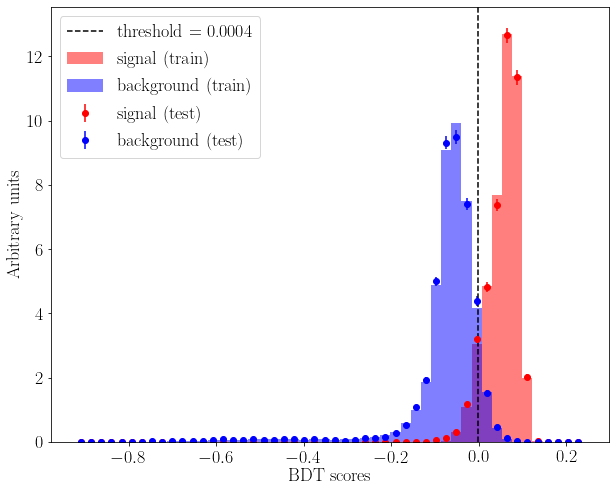

In [22]:
scores_train_test(bdt_SAMME_R,X_train,y_train,X_test,y_test)

thr = 0.0004

In [12]:
blackbox = pd.read_csv('../notebooks/TablularDataUpdatedCode/combined_Blackbox3.csv', sep=',')

In [13]:
blackbox.shape

(1000000, 31)

In [14]:
blackbox.keys()

Index(['pt_j1', 'm_j1', 'eta_j1', 'phi_j1', 'E_j1', 'pt_j2', 'm_j2', 'eta_j2',
       'phi_j2', 'E_j2', 'deltaeta', 'deltaphi', 'mEratio1', 'mEratio2',
       'm_jj', 'pt_asym', 'deltaR1_sj12', 'deltaR1_sj13', 'deltaR1_sj14',
       'deltaR1_sj23', 'deltaR1_sj24', 'deltaR1_sj34', 'deltaR2_sj12',
       'deltaR2_sj13', 'deltaR2_sj14', 'deltaR2_sj23', 'deltaR2_sj24',
       'deltaR2_sj34', 'n_subjets1', 'n_subjets2', 'event_idx'],
      dtype='object')

In [15]:
blackbox.drop(['event_idx'], axis=1, inplace=True)

In [16]:
decisions_bb = bdt_SAMME_R.decision_function(blackbox)

In [17]:
decisions_bb.shape

(1000000,)

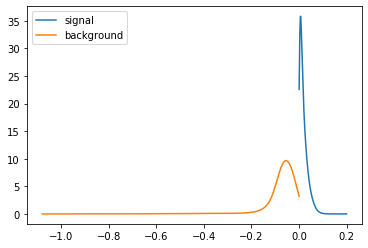

In [18]:
density_sig = gaussian_kde(decisions_bb[decisions_bb > 0.0004])
density_bg = gaussian_kde(decisions_bb[decisions_bb < 0.0004])
xs_sig = np.linspace(min(decisions_bb[decisions_bb > 0.0004]),
                     max(decisions_bb[decisions_bb > 0.0004]),200)
xs_bg = np.linspace(min(decisions_bb[decisions_bb < 0.0004]),
                    max(decisions_bb[decisions_bb < 0.0004]), 200)

density_sig.covariance_factor = lambda : .25
density_sig._compute_covariance()
density_bg.covariance_factor = lambda : .25
density_bg._compute_covariance()
plt.plot(xs_sig,density_sig(xs_sig),label='signal')
plt.plot(xs_bg,density_bg(xs_bg),label='background')
plt.legend()
plt.show()

In [19]:
pValue = stats.ks_2samp(density_bg(xs_bg),density_sig(xs_sig))

In [20]:
pValue

Ks_2sampResult(statistic=0.255, pvalue=4.024806511439489e-06)

In [ ]:
xs_sig2 = np.linspace(min(decisions_bb),
                     max(decisions_bb),200)
xs_bg2 = np.linspace(min(decisions_bb),
                    max(decisions_bb), 200)


density_sig.covariance_factor = lambda : .25
density_sig._compute_covariance()
density_bg.covariance_factor = lambda : .25
density_bg._compute_covariance()
plt.plot(xs_sig,density_sig(xs_sig2),label='signal')
plt.plot(xs_bg,density_bg(xs_bg2),label='background')
plt.legend()
plt.show()

In [ ]:
stats.ks_2samp(density_bg(xs_bg2),density_sig(xs_sig2))

## Export the selected threshold data

In [21]:
len(decisions_bb[decisions_bb >  0.004])

58276

In [30]:
threshold =  0.04

- The index in the decisions_bb and blackbox dataframe are the same, so I can mask the blackobox dataframe with these indexes and export the data we want.

In [31]:
#select the indexes we want for an given threshold:
select_signal_idx = np.where(decisions_bb > threshold)[0]
select_bg_idx = np.where(decisions_bb < threshold)[0]

In [32]:
# using the indexes to mask the dataframe:
df_sig_selceted = blackbox.loc[select_signal_idx]
df_bg_selected = blackbox.loc[select_bg_idx]

In [33]:
df_sig_selceted.head()

,pt_j1,m_j1,eta_j1,phi_j1,E_j1,pt_j2,m_j2,eta_j2,phi_j2,E_j2,...,deltaR1_sj24,deltaR1_sj34,deltaR2_sj12,deltaR2_sj13,deltaR2_sj14,deltaR2_sj23,deltaR2_sj24,deltaR2_sj34,n_subjets1,n_subjets2
384,1344.196307,100.258403,-0.742778,-2.378998,1735.269754,1298.826614,510.904603,0.596752,0.612656,1619.723366,...,0.000000,0.000000,0.964577,0.680606,0.680606,1.580849,1.580849,0.0,1,2
424,1750.053592,120.822496,0.563091,1.003319,2038.492450,1628.687969,481.850875,-0.272357,-2.212616,1756.839881,...,0.000000,0.000000,0.644104,2.143872,2.143872,2.502737,2.502737,0.0,1,2
534,1731.682655,462.168597,0.353116,-2.997413,1897.903993,1630.124180,159.308842,0.581111,0.121001,1919.817224,...,3.100877,0.000000,0.584557,0.584557,0.584557,0.000000,0.000000,0.0,2,1
574,1257.536292,115.657443,-0.151569,-1.739767,1277.256014,1164.196272,462.566852,1.797524,1.545537,3638.761380,...,0.000000,0.000000,0.784317,2.565961,2.565961,1.866619,1.866619,0.0,1,2
734,1223.031381,482.527297,1.425202,-1.324367,2733.085678,1209.768212,466.903745,-0.218110,1.821545,1323.734291,...,2.378453,1.423042,0.741420,2.051077,2.051077,1.370213,1.370213,0.0,3,2


In [34]:
df_bg_selected.head()

,pt_j1,m_j1,eta_j1,phi_j1,E_j1,pt_j2,m_j2,eta_j2,phi_j2,E_j2,...,deltaR1_sj24,deltaR1_sj34,deltaR2_sj12,deltaR2_sj13,deltaR2_sj14,deltaR2_sj23,deltaR2_sj24,deltaR2_sj34,n_subjets1,n_subjets2
0,1620.333864,685.115973,-0.174478,-1.614655,1782.023078,1585.701346,134.002458,1.312144,1.548500,3161.059175,...,0.878934,1.417791,2.032764,2.032764,2.032764,0.000000,0.000000,0.000000,5,1
1,1360.556699,561.077186,0.517355,-1.318315,1645.356355,1329.648922,171.592563,0.379208,1.834474,1436.684733,...,1.393768,0.870271,1.880787,1.880787,1.880787,0.000000,0.000000,0.000000,3,1
2,1386.828215,307.755761,0.262895,2.057175,1467.659061,1270.418039,287.348589,-0.768561,-1.364765,1689.085517,...,1.625738,0.000000,0.583448,0.766499,1.571579,0.715270,1.380219,2.087638,2,3
3,1273.796306,48.893264,0.724323,2.511642,1623.543917,1241.645039,212.022430,-0.539519,-0.629352,1442.448262,...,0.000000,0.000000,0.735084,0.848101,0.848101,0.546064,0.546064,0.000000,1,2
4,1437.517476,174.676116,-0.312343,1.842724,1518.291486,1421.652283,185.871476,-1.219979,-1.346753,2624.104551,...,0.000000,0.000000,1.817343,1.817343,1.817343,0.000000,0.000000,0.000000,1,1


In [35]:
#check the lenght and if the shapes match with the original dataframe:
df_bg_selected.shape, df_sig_selceted.shape

((992225, 30), (7775, 30))

In [36]:
df_bg_selected.shape[0] + df_sig_selceted.shape[0] == blackbox.shape[0]

True

In [37]:
# export the selected data to csv:
#df_sig_selceted.to_csv('../selected data csv BL3/signal/selected_signal_thr_0d04.csv', sep=',')
#df_bg_selected.to_csv('../selected data csv BL3/background/selected_background_thr_0d04.csv', sep=',')

In [41]:
blackbox[(blackbox['m_j1'] > 50.) & (blackbox['m_j1'] < 150.)].m_j1.describe()

count    359690.000000
mean        101.135451
std          27.589875
min          50.001051
25%          78.202955
50%         101.080212
75%         124.434239
max         149.999839
Name: m_j1, dtype: float64

In [42]:
df_sig_selceted[(df_sig_selceted['m_j1'] > 50.) & (df_sig_selceted['m_j1'] < 150.)].m_j1.describe()

count    3021.000000
mean      112.927662
std        14.611070
min        73.523839
25%       102.127862
50%       111.563898
75%       122.553776
max       149.920184
Name: m_j1, dtype: float64

In [43]:
len(df_sig_selceted[(df_sig_selceted['m_j1'] > 50.) & (df_sig_selceted['m_j1'] < 150.)])

3021